In [ ]:
! git clone https://github.com/miamvmian/Sk-ML-FNO-Project-2024.git

In [24]:
# %run fdm_scheme_constructor.ipynb
import os
from pathlib import PurePath


cwd = os.getcwd()
p = PurePath(cwd)
# os.chdir('Sk-ML-FNO-Project-2024')
if p.parts[-1] != 'Sk-ML-FNO-Project-2024':
  os.chdir('Sk-ML-FNO-Project-2024')
print(f"Current Folder is: {os.getcwd()}")


Sk-ML-FNO-Project-2024


In [16]:
# ! git clone import Adam
# ! git clone import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

fatal: repository 'import' does not exist
fatal: repository 'import' does not exist


In [4]:
import itertools
from functools import partial
from math import erf as erf_, exp as exp_, sin
from typing import Optional

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import numpy.typing as npt
import numba.types as nbt
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import pi, sqrt
from sklearn.model_selection import train_test_split
from torch.nn.parameter import Parameter
from tqdm import tqdm

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()

        """1D Fourier layer: FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels

        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes = modes

        self.scale = 1. / (in_channels*out_channels)
        self.weights = nn.Parameter(self.scale
                                    * torch.rand(
                                        self.in_channels,
                                        self.out_channels,
                                        self.modes,
                                        dtype=torch.cdouble))

        # self.einsum_path_ = None

    def batch_complex_mult(self, input, weights):
        """Multiply the complex weights and input using the following
            tensorial contraction along the in_channel:
            (batch, in_channel, x_i) * (in_channel, out_channel, x_w)
                -> (batch, out_channel, x)

            Note that the x dim is kept, so there is no summation
            going on along it.


            In other words, perform a linear transform
            in the complex plane.
        """

        # if self.einsum_path_ is None:
        #     path = np.einsum_path(
        #         'bix,iox->box',
        #         input,
        #         weights,
        #         optimize='optimal')[0]

        # return np.einsum(
        #     'bix,iox->box',
        #     input,
        #     weights,
        #     optimize=self.einsum_path_)

        return torch.einsum(
            'bix,iox->box',
            input,
            weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coeff's up to a factor of modulus 1 (phase info)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1)//2 + 1,
            device=x.device,
            dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = self.batch_complex_mult(
            x_ft[:, :, :self.modes],
            self.weights)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))

        return x

In [ ]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desired channel dimension
            by self.fc0_dim_lift.
        2. 4 layers of integral operators u' = (W + K)(u) with
            W defined by self.bias_w{k}; K defined by self.conv{k}.
        3. Project from the channel space to some lower dimensional space
            by self.fc1_dim_lower, apply a non-linear activation function,
            and project back to the output space by self.fc2.

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.padding = 2  # pad the domain if input is non-periodic
        self.fc0_dim_lift = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.bias_w0 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w1 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w2 = nn.Conv1d(self.width, self.width, 1)
        self.bias_w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1_dim_lower = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0_dim_lift(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.bias_w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.bias_w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.bias_w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.bias_w3(x)
        x = x1 + x2

        x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1_dim_lower(x)
        x = F.gelu(x)
        x = self.fc2(x)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(
            np.linspace(0, 1, size_x),
            dtype=torch.float64)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])

        return gridx.to(device)

In [6]:
# from utilities3 import *


# ntrain = 1000
# ntest = 100

# sub = 2**3 #subsampling rate
# h = 2**13 // sub #total grid size divided by the subsampling rate
# s = h

# batch_size = 20
# learning_rate = 0.001

# epochs = 500
# step_size = 50
# gamma = 0.5

# modes = 16
# width = 64


# ################################################################
# # read data
# ################################################################

# # Data is of the shape (number of samples, grid size)
# dataloader = MatReader('./burgers_data_R10.mat')
# x_data = dataloader.read_field('a')[:,::sub]
# y_data = dataloader.read_field('u')[:,::sub]

# x_train = x_data[:ntrain,:]
# y_train = y_data[:ntrain,:]
# x_test = x_data[-ntest:,:]
# y_test = y_data[-ntest:,:]

# x_train = x_train.reshape(ntrain,s,1)
# x_test = x_test.reshape(ntest,s,1)

In [ ]:
full_a = np.loadtxt(
    'gen-burgers-fisher-t0-small-out.csv', delimiter=',')
full_u = np.loadtxt(
    'gen-burgers-fisher-t0.1-small-out.csv', delimiter=',')

In [ ]:
a_train, a_test, u_train, u_test = train_test_split(
    # torch.tensor(full_a),
    # torch.tensor(full_u),
    torch.from_numpy(full_a),
    torch.from_numpy(full_u),
    test_size=0.33,
    random_state=42)

In [ ]:
batch_size = 20

a_train = a_train.reshape(*a_train.shape, 1)
# u_train = u_train.reshape(*u_train.shape, 1)

a_test = a_test.reshape(*a_test.shape, 1)
#u_test = u_test.reshape(*a_test.shape, 1)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(a_train, u_train),
    batch_size=batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(a_test, u_test),
    batch_size=batch_size,
    shuffle=False)

In [ ]:
modes = 16
width = 64

# model = FNO1d(modes, width).cuda()
model = FNO1d(modes, width).double().cuda()
# print(count_params(model))

In [ ]:
def train_model(
        epochs,
        loss,
        optimizer,
        scheduler):
    for epoch in tqdm(range(epochs)):
        model.train()
        t1 = timeit.default_timer()
        train_mse = 0
        train_l2 = 0

        for x, y in tqdm(train_loader):
            # x, y = x.cuda(), y.cuda()
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            out = model(x)

            mse = F.mse_loss(
                out.view(batch_size, -1),
                y.view(batch_size, -1),
                reduction='mean')
            l2 = loss(
                out.view(batch_size, -1),
                y.view(batch_size, -1))
            l2.backward()

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in tqdm(test_loader):
                # x, y = x.cuda(), y.cuda()
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += loss(
                    out.view(batch_size, -1),
                    y.view(batch_size, -1)).item()

        train_mse /= len(train_loader)
        train_l2 /= u_train.shape[0]
        test_l2 /= u_test.shape[0]

        t2 = timeit.default_timer()
        print(epoch, t2-t1, train_mse, train_l2, test_l2)

In [14]:
from Adam import Adam

SyntaxError: invalid syntax (<ipython-input-14-4d3dbb6de67e>, line 1)

In [ ]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

In [ ]:
learning_rate = 0.001
step_size = 50
gamma = 0.5
optimizer = Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma)

myloss = LpLoss(size_average=False)

In [ ]:
torch.backends.cpu.get_cpu_capability()
# torch.backends.nnpack.enabled = False

'NO AVX'

In [ ]:
train_model(
    20,
    myloss,
    optimizer,
    scheduler)

  0%|                                                            | 0/20 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# def gen_burgers_fisher_init_cond(alpha=0, delta=1, n_pts=10000):
#     a = 0.
#     b = 1.
#     dx = (b - a) / (n_pts - 1)
#     x = np.zeros(n_pts)
#     x = np.asarray([a + k*dx for k in range(n_pts)])

#     return (0.5 + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*x)))**(1./delta)

In [ ]:
# def gen_burgers_fisher_sol(
#         alpha=1.,
#         beta=0.0001,
#         delta=1.,
#         t_max=1.,
#         n_pts=10000,
#         n_time_slices=1000):
#     a = 0.
#     b = 1.
#     dx = (b - a) / (n_pts - 1)
#     x = np.zeros(n_pts)
#     x = np.asarray([a + k*dx for k in range(n_pts)])
#     arr = np.empty((n_time_slices, n_pts))

#     dt = t_max / (n_time_slices - 1)

#     for k in range(n_time_slices):
#         t = k*dt
#         arr[k, :] = (0.5
#                   + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*(
#                       x - (alpha/(delta+1) + beta*(delta+1)/alpha)*t))))**(1./delta)

#     return arr

In [ ]:
# gen_burgers_fisher_sol(
#         alpha=1., beta=0.0001, delta=1, t_max=1., n_pts=10000, n_time_slices=1000)

In [ ]:
def gen_burgers_fisher_sol(
        alpha=1.,
        beta=0.0001,
        delta=1.,
        t_max=1.,
        n_pts=10000):
    a = 0.
    b = 1.
    dx = (b - a) / (n_pts - 1)
    x = np.zeros(n_pts)
    x = np.asarray([a + k*dx for k in range(n_pts)])
    arr = np.empty((1, n_pts))

    arr[0, :] = (0.5
                 + 0.5*np.tanh((-alpha*delta/(delta+1)*0.5*(
                     x - (alpha/(delta+1) + beta*(delta+1)/alpha)*t_max))))**(1./delta)

    return arr

In [ ]:
import itertools


def generate_solution_matrix(
        alpha_range, beta_range, delta_range, t_max, n_pts):
    rng = list(itertools.product(alpha_range, beta_range, delta_range))
    arr = np.empty((len(rng), n_pts))
    # arr = np.empty((n_pts, len(rng)))

    for k, (alpha, beta, delta) in enumerate(rng):
        arr[k, :] = gen_burgers_fisher_sol(
            alpha, beta, delta, t_max, n_pts)
        # arr[:, k] = gen_burgers_fisher_sol(
        #     alpha, beta, delta, t_max, n_pts)

    return arr

In [ ]:
def equidistant_val_array(start, end, n_pts):
    a = start
    b = end
    dx = (b - a) / (n_pts - 1)
    x = np.zeros(n_pts)
    x = np.asarray([a + k*dx for k in range(n_pts)])

    return x

In [ ]:
# alphas = equidistant_val_array(-10, 10, 20)
alphas = [-0.0001]  # , 0.0001, 1, 500
# alphas
betas = equidistant_val_array(-0.4, 0.4, 8000)
# betas
deltas = [1]  # , 2, 3

In [ ]:
# res = generate_solution_matrix(
#         alphas, betas, deltas, 0., 10001)

In [ ]:
# import pandas as pd


# full_a = pd.read_csv('gen-burgers-fisher-t0-small-out.csv')
# full_u = pd.read_csv('gen-burgers-fisher-t0.1-small-out.csv')
# # train_data.head()

In [ ]:
# full_a.shape

(10001, 8000)

In [ ]:
# full_a[:, 20]

array([0.5      , 0.5      , 0.5      , ..., 0.5000125, 0.5000125,
       0.5000125])

In [ ]:
# full_u[:, 20]

array([0.49005132, 0.49005132, 0.49005132, ..., 0.49006381, 0.49006381,
       0.49006381])

In [ ]:
# equidistant_val_array(-1., 1., 10001)[1] - equidistant_val_array(-1., 1., 10001)[0]
# equidistant_val_array(-1., 1., 10000)
# equidistant_val_array(-1., 1., 10001)[0]

0.00019999999999997797

In [ ]:
# 2/(10001-1)

0.0002

In [ ]:
# full_a.head(2)

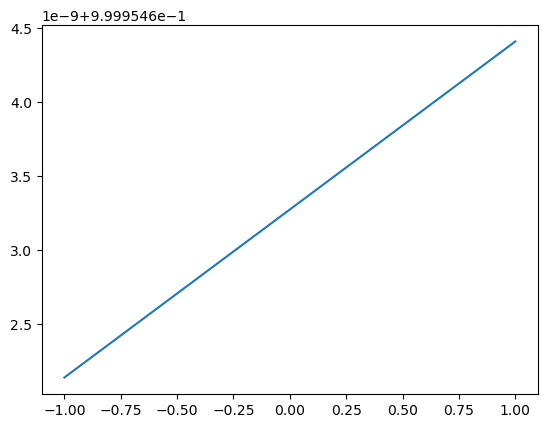

In [ ]:
# plt.plot(equidistant_val_array(-1, 1, 10001), gen_burgers_fisher_sol(
#     -0.0001, 0.2, 1., t_max=50, n_pts=10001)[0])

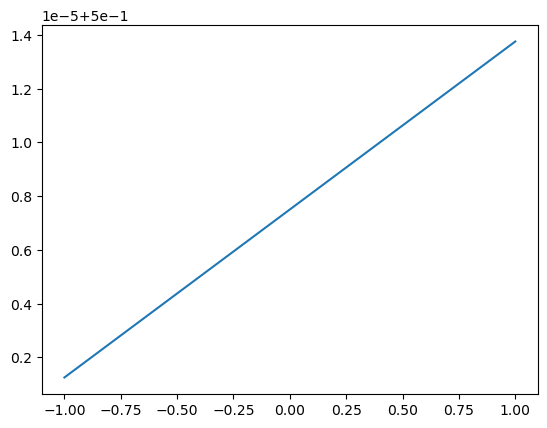

In [ ]:
# plt.plot(equidistant_val_array(-1, 1, 10000), res[:, 4000])

In [ ]:
# print(gen_burgers_fisher_sol(
#             0.0001, 0.001, t_max=50, n_pts=10000))

[[0.51249743 0.51249743 0.51249743 ... 0.51248494 0.51248494 0.51248494]]


In [ ]:
# np.savetxt(
#     'gen-burgers-fisher-t0-small-out.csv',
#     res,  # res.T,
#     # header=','.join(["x", "y", "z"]),
#     delimiter=',',
#     # fmt='%.0f',
#     comments='')

In [ ]:
# del res